## Multi Pendulum Cart Problem

In [223]:
%matplotlib inline
import sympy
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sympy import Matrix, MatrixSymbol, Symbol, symbols, cos, sin, BlockMatrix
from scipy.linalg import solve_continuous_are
from scipy.signal import place_poles, step, lti
from scipy import signal
from tqdm import tqdm

In [224]:
# image dir
image_dir = "image"
os.makedirs(image_dir,exist_ok=True)

## Declare the symbols

In [175]:
x, theta1, theta2, u = symbols(r"x \theta_1 \theta_2 u")
x_dot, theta1_dot, theta2_dot = symbols(r"\dot{x} \dot{\theta_1} \dot{\theta_2}")
x_ddot, theta1_ddot, theta2_ddot = symbols(r"\ddot{x} \ddot{\theta_1} \ddot{\theta_2}")
state = Matrix([x,x_dot, theta1, theta1_dot, theta2, theta2_dot])

# variables
m1, m2, M = symbols("m1 m2 M") # oz
l1, l2 = symbols("l1 l2") # in
g = 9.81 #m/s2

variables = {m1:100,m2:100, l1:20, l2:10, M:1000}   

# ## 
# x_ddot = (u-(g/2)*(m1*sin(2*theta1)+m2*sin(2*theta2))-(m1*l1*(theta1_dot**2)*sin(theta1))-(m2*l2*(theta2_dot**2)*sin(theta2))
#          )/(M+m1*((sin(theta1))**2)+m2*((sin(theta2))**2))
# x_ddot = x_ddot.subs(variables)
# theta1_ddot = x_ddot*cos(theta1)/l1 - g*sin(theta1)/l1
# theta2_ddot = x_ddot*cos(theta2)/l2 - g*sin(theta2)/l2
# theta1_ddot =  theta1_ddot.subs(variables)
# theta2_ddot = theta2_ddot.subs(variables)

In [176]:
state

Matrix([
[             x],
[       \dot{x}],
[      \theta_1],
[\dot{\theta_1}],
[      \theta_2],
[\dot{\theta_2}]])

In [177]:

N = 6 #number of tate
A = Matrix([[0,1,0,0,0,0],
            [0,0,-(m1*g)/M,0,-(m1*g)/M,0],
            [0,0,0,1,0,0],
            [0,0,-((M+m1)*g)/(M*l1),0,-(m2*g)/(M*l1),0],
            [0,0,0,0,0,1],
            [0,0,-(m1*g)/(M*l2),0,-(g*(M+m2))/(M*l2),0]])
R = Matrix([.003])
B = Matrix([0,1/M,0,1/(M*l1),0,1/(M*l2)])
Q = sympy.eye(N,N)*150

A_sub = A.subs(variables)
B_sub = B.subs(variables)
A_arr = np.array(A_sub,dtype=np.float32)
B_arr = np.array(B_sub,dtype=np.float32)
Q_arr = np.array(Q,dtype=np.float32)
R_arr = np.array(R,dtype=np.float32)

In [178]:

N = 6 #number of tate
A = Matrix([[0,1,0,0,0,0],
            [0,0,-(m1*g)/M,0,-(m1*g)/M,0],
            [0,0,0,1,0,0],
            [0,0,-((M+m1)*g)/(M*l1),0,-(m2*g)/(M*l1),0],
            [0,0,0,0,0,1],
            [0,0,-(m1*g)/(M*l2),0,-(g*(M+m2))/(M*l2),0]])
R = Matrix([.005])
B = Matrix([0,1/M,0,1/(M*l1),0,1/(M*l2)])
C = sympy.eye(N,N)
Q = sympy.eye(N,N)*150

A_sub = A.subs(variables)
B_sub = B.subs(variables)
A_arr = np.array(A_sub,dtype=np.float32)
B_arr = np.array(B_sub,dtype=np.float32)
Q_arr = np.array(Q,dtype=np.float32)
R_arr = np.array(R,dtype=np.float32)

In [179]:
print(sympy.latex(C))

\left[\begin{matrix}1 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 0\\0 & 0 & 0 & 0 & 0 & 1\end{matrix}\right]


## LQR 
Solves the continuous algebraic Riccati equation, or CARE, defined as 
$$(A^TP + PA - PBR^{-1}B^TP+Q=0)$$
directly using a Schur decomposition method.

Then compute $K = -R^{-1}B^TP$ the optimal solution to LQR Control problem

In [180]:
P = solve_continuous_are(A_arr,B_arr,Q_arr,R_arr)
K_arr = -(np.linalg.inv(R_arr)@B_arr.T@P)
K_arr = np.round(K_arr,3)
K = Matrix(K_arr)
K

Matrix([[-173.205, -665.416, 69.025, 597.953, 13.497, 295.616]])

### Defining State Space equation
$$
\dot x  = Ax+BKu
$$
$$
Y = Cx
$$
Calculating next state, for given $\delta t$ (dt) time interval.

In [181]:
def state_space_model(A,B,C,state,input,dt):
    state_dot = A*state + B * input
    Y = C*state
    next_states = state + state_dot*dt
    return next_states,Y

In [182]:
def non_linear_state_space_model(x_states):
    x_ddot = (x_states[u]-(g/2)*(variables[m1]*np.sin(2*math.radians(x_states[theta1])
        )+variables[m2]*math.sin(2*math.radians(x_states[theta2]))
        )-(variables[m1]*variables[l1]*(x_states[theta1_dot]**2)*np.sin(math.radians(x_states[theta1]))
        )-(variables[m2]*variables[l2]*(x_states[theta2_dot]**2)*math.sin(math.radians(x_states[theta2])))
         )/(variables[M]+variables[m1]*((np.sin(math.radians(x_states[theta1])))**2)+variables[m2]*((np.sin(math.radians(x_states[theta2])))**2))
    theta1_ddot = x_ddot*np.cos(math.radians(x_states[theta1]))/variables[l1] - g*np.sin(math.radians(x_states[theta1]))/variables[l1]
    theta2_ddot = x_ddot*np.cos(math.radians(x_states[theta2]))/variables[l2] - g*np.sin(math.radians(x_states[theta2]))/variables[l2]
    # x_ddot_sub = x_ddot.subs(x_states)
    # theta1_ddot_sub = theta1_ddot.subs(x_states)
    # theta2_ddot_sub = theta2_ddot.subs(x_states)
    # non_linear_state = Matrix([x_states[x_dot],x_ddot_sub, x_states[theta1_dot], theta1_ddot_sub, x_states[theta2_dot], theta2_ddot_sub])
    non_linear_state = Matrix([x_states[x_dot],x_ddot, x_states[theta1_dot], theta1_ddot, x_states[theta2_dot], theta2_ddot])
    return non_linear_state

## Running LQR Controller
* Running for total time = $1000$ sec, and $dt = 0.01$ sec. 
* Initial Condition is defined as 
$$ X(0) = [0,0,30,0,40,0]$$

In [183]:
def state_space(A,B,C,ue_controller=True):
    total_time = 500
    dt = .01

    Ts = np.arange(0,total_time,dt)

    X_states = {x:0,x_dot:0, theta1:30, theta1_dot:0, theta2:40, theta2_dot:0, u:0}
    curr_state = state.subs(X_states)
    output = []
    non_linear_outputs = []
    # print("\ncurrent_states: ",X_states)
    if ue_controller:
        optimal_control_input = K
        A_new = A + B*optimal_control_input
    else:
        # Take initial condition here input u i 0.
        optimal_control_input = 0
        A_new = A

    for i in tqdm(Ts):
        u_temp = (optimal_control_input*curr_state)[0]
        X_states = {x:curr_state[0],x_dot:curr_state[1], theta1:curr_state[2], theta1_dot:curr_state[3], theta2: curr_state[4], theta2_dot:curr_state[5], u:u_temp}
        next_state,Y = state_space_model(A_new,B,C,curr_state,0,dt)
        non_linear_output = non_linear_state_space_model(X_states)
        curr_state=next_state
        # print(curr_state)
        # print(X_states)
        # print("#######")
        output.append(Y)
        non_linear_outputs.append(non_linear_output)
        # print(non_linear_output)
    output_arr = np.array(output,dtype=np.float32).squeeze()
    # print(non_linear_outputs)
    non_linear_output_arr = np.array(non_linear_outputs,dtype=np.float32).squeeze()

    return output_arr, non_linear_output_arr, Ts

In [184]:
x_states = {x:0,x_dot:0, theta1: math.radians(30), theta1_dot:0, theta2:math.radians(40), theta2_dot:0, u:0}

# x_states = {x:0,x_dot:0, theta1: 30, theta1_dot:0, theta2 : 40, theta2_dot:0, u:0}
%timeit non_linear_state_space_model(x_states)

344 µs ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [205]:
def state_space_observer(A,B,C,L):
    total_time = 500
    dt = .01

    Ts = np.arange(0,total_time,dt)
    states = Matrix(BlockMatrix([[state],[sympy.zeros(*state.shape)]])) # state with state estimates
    X_states = {x:0,x_dot:0, theta1:30, theta1_dot:0, theta2: 40, theta2_dot:0}
    curr_state = states.subs(X_states)
    output = []
    
    A_block = Matrix(BlockMatrix([[A+B*K,-B*K],[sympy.zeros(*A.shape),A-L*C]]))
    B_block = Matrix(BlockMatrix([[B],[sympy.zeros(*B.shape)]]))
    C_block = Matrix(BlockMatrix([C,sympy.zeros(*C.shape)]))
    D_block = sympy.zeros(C.shape[0],1)
    optimal_control_input = Matrix(BlockMatrix([K,sympy.zeros(*K.shape)]))
    
    A_block_arr = np.array(A_block,dtype=np.float32)
    B_block_arr = np.array(B_block,dtype=np.float32)
    C_block_arr = np.array(C_block,dtype=np.float32)
    D_block_arr = np.array(D_block,dtype=np.float32)
    inp = 0
    non_linear_outputs = []
    for i in tqdm(Ts):
        u_temp = (optimal_control_input*curr_state)[0]
        X_states = {x:curr_state[0],x_dot:curr_state[1], theta1:curr_state[2], theta1_dot:curr_state[3], theta2: curr_state[4], theta2_dot:curr_state[5], u:u_temp}
        next_state,Y = state_space_model(A_block,B_block,C_block,curr_state,0,dt)
        
        non_linear_output = non_linear_state_space_model(X_states)
        curr_state=next_state
        
        output.append(Y)
        non_linear_outputs.append(non_linear_output)
        # print(non_linear_output)
    output_arr = np.array(output,dtype=np.float32).squeeze()
    # print(non_linear_outputs)
    non_linear_output_arr = np.array(non_linear_outputs,dtype=np.float32).squeeze()
    output_arr = np.array(output,dtype=np.float32).squeeze()
    return output_arr, non_linear_output_arr, Ts, (A_block_arr,B_block_arr,C_block_arr,D_block_arr)

In [206]:
def plot_respone(output_arr, time_steps, N, state, plot_title = "Controller Response", Plot_filename = "Controller Response", save = False):
    try:
        N_min = min([output_arr.shape[1],N])
    except:
        N_min = 1
    print(N_min)
    fig, axs = plt.subplots(N_min,1,sharex=True)
    fig.suptitle(plot_title)
    fig.tight_layout()
    if N_min>1:
        # fig.a ("time steps (sec)")
        for n in range(N_min):
            axs[n].set_ylabel(rf"${state[n]}$")
            axs[n].set_xlabel("Time steps (sec)")
            axs[n].plot(time_steps, output_arr[:,n])
            axs[n].label_outer()
    else:
        axs.set_ylabel(rf"${state}$")
        axs.set_xlabel("Time steps (sec)")
        axs.plot(time_steps, output_arr[:])
        axs.label_outer()
    # plt.savefig("InitialResponseWithoutController.png")
    if save:
        plt.savefig(f"{image_dir}/{'_'.join(Plot_filename.split())}.png", bbox_inches='tight')

### Running state space system and plotting without LQR controller

plot_respone(output_arr_wo_control,time_steps,N, plot_title="Response Without Controller")

### Running state space system and plotting with LQR controller


In [160]:
# Running state space with LQR controller
output_arr, non_linear_output_arr, time_steps = state_space(A_sub,B_sub,C,True)

100%|██████████| 50000/50000 [03:02<00:00, 273.74it/s]


6


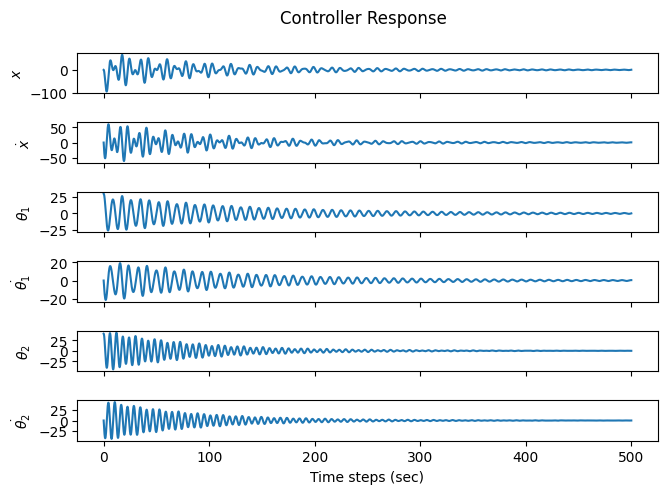

In [190]:
plot_respone(output_arr,time_steps,N,state,save=True)

6


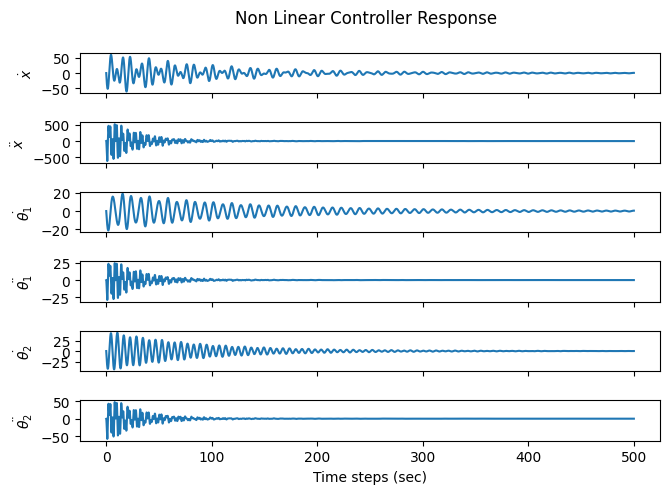

In [191]:
# Non linear plotting
plot_respone(non_linear_output_arr,time_steps,N,state=[x_dot,x_ddot,theta1_dot,theta1_ddot,theta2_dot,theta2_ddot],plot_title="Non Linear Controller Response", Plot_filename="Non Linear Controller Response",save=True)

## Observability of state space

In [199]:
C1 = (Matrix([[1,0,0,0,0,0]]),x)
C2 = (Matrix([[0,0,1,0,0,0],[0,0,0,0,1,0]]),(theta1,theta2))
C3 = (Matrix([[1,0,0,0,0,0],[0,0,0,0,1,0]]),(x,theta2))
C4 = (Matrix([[1,0,0,0,0,0],[0,0,1,0,0,0],[0,0,0,0,1,0]]),(x,theta1,theta2))
Cs_temp = [C1,C2,C3,C4]
Cs = []
for c,st in Cs_temp:
    
    observer =  Matrix(BlockMatrix([[c*A**i] for i in range(N)]))
    rk = observer.rank()
    if rk==N:
        # sympy.pprint(st)
        print(f"{st} is observable")
        Cs.append((c,st))
    else:
        print(f"{st} is not observable")

x is observable
(\theta_1, \theta_2) is not observable
(x, \theta_2) is observable
(x, \theta_1, \theta_2) is observable


## Luenberger Observer

In [200]:
# Find the L for above given output vector
# Fixing eigen values for the A-L, we can reversely find L
Ls = []
eig = np.array(Matrix([-1,-1.5,-2, -2.5, -3,-3.5]),dtype=np.float32).reshape(-1,)
for c, st in Cs:
    C_arr = np.array(c.T,dtype=np.float32)
    print(C_arr.shape,A_arr.shape)
    out = place_poles(A_arr,C_arr,eig)
    O = np.round_(out.gain_matrix,3)
    L = Matrix(O).T
    Ls.append(L)
    print(L)
    # print(sympy.latex(L))

(6, 1) (6, 6)
Matrix([[2.50000000000000], [-1.99707132797425e+15], [1.95631477026049e+15], [2.26334750503748e+15], [-3.30671538250974e+15], [4.77123435635752e+15]])
(6, 2) (6, 6)


/home/skynet/.local/lib/python3.8/site-packages/scipy/signal/_ltisys.py:3358: UserWarning: Convergence was not reached after maxiter iterations.
You asked for a relative tolerance of 0.001000 we got 1.000000
  warnings.warn(err_msg)


Matrix([[3.03500000000000, 0.0470000000000000], [-5.53898384948067e+15, -248048348358178.], [4010.61700000000, -296.014000000000], [9.23163971407697e+15, 413413912360345.], [-25.9380000000000, 6.87900000000000], [4.61581985703909e+15, 206706956180179.]])
(6, 3) (6, 6)
Matrix([[1.64500000000000, 0.605000000000000, -0.0850000000000000], [-352680596653506., 2.57701537016985e+15, 70493020208623.1], [0.333000000000000, 5.32600000000000, 0.871000000000000], [587800992190371., -4.29502560063966e+15, -117488366568221.], [-0.106000000000000, 2.90600000000000, 5.33700000000000], [293900496095186., -2.14751280031983e+15, -58744183284113.8]])


In [207]:
all_step_output = []
all_output_arr_control_observe = []
all_output_arr_control_observe_non_linear = []
all_sys = []
for c, l in zip(Cs,Ls):
    output_arr_control_observe, non_linear_output_arr_control_observe , time_steps, sys = state_space_observer(A_sub,B_sub,c[0],l)
    all_output_arr_control_observe.append(output_arr_control_observe)
    all_output_arr_control_observe_non_linear.append(non_linear_output_arr_control_observe)
    t, Y = signal.step2(sys,T=time_steps)
    all_step_output.append(Y)
    all_sys.append(sys)

100%|██████████| 50000/50000 [08:18<00:00, 100.27it/s]


3


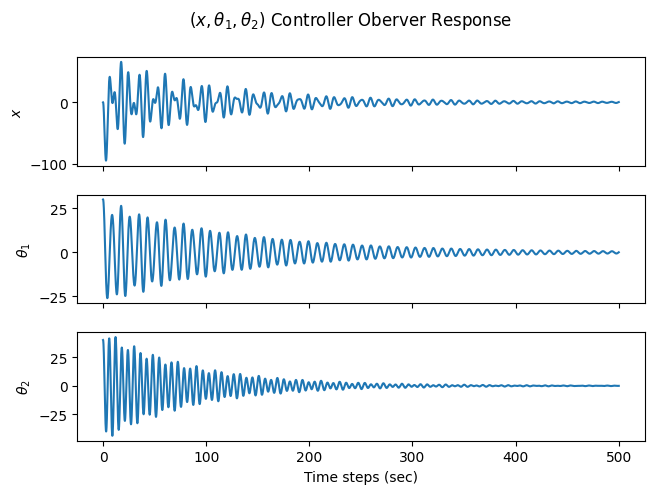

In [219]:
plot_respone(all_output_arr_control_observe[2],time_steps,N,Cs[2][1],plot_title=f"${Cs[2][1]}$ Controller Oberver Response",Plot_filename="x_theta1_theta2_Controller+OberverResponse", save=True)

In [ ]:
plot_respone(all_output_arr_control_observe[2],time_steps,N,Cs[2][1],plot_title=f"${Cs[2][1]}$ Controller Oberver Response",Plot_filename="x_theta1_theta2_Controller+OberverResponse-non-linear", save=False)

3


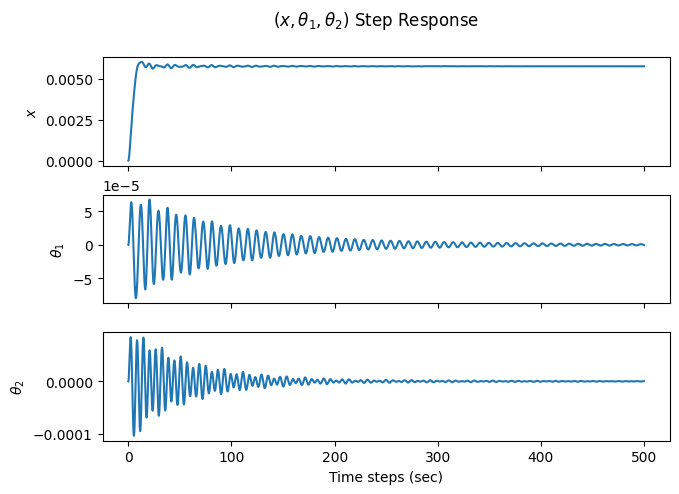

In [222]:
plot_respone(all_step_output[2],time_steps,N,Cs[2][1], plot_title=f"${Cs[2][1]}$ Step Response", Plot_filename ="x_theta1_theta2_Controller+OberverStepResponse",save=True)

## Printing $P$

In [ ]:

P_round = np.round(P,2)
P_sub = Matrix(P_round)
print(sympy.latex(K))

In [ ]:
print(sympy.latex(P_sub.det()))

In [ ]:
print(P)

In [ ]:
EIG = np.linalg.eigvals(A_arr+B_arr@K_arr)
EIG = np.round(EIG,3)
EIG_sy = Matrix(EIG)